<hr style="border-width:4px; border-color:coral"></hr>

# Practice

<hr style="border-width:4px; border-color:coral"></hr>

This notebook will cover 

* Running large number of independent jobs using a Queue.  



In [1]:
import multiprocessing as mp
mp.set_start_method('fork')

Starting with Python 3.8, the default start method is 'spawn'.  However, this does not work well in Jupyter notebooks.   The following code will set the start method to `fork`. 

Test your code with this small example

In [2]:
def debug():
    print("In process debug")
    
p = mp.Process(target=debug)    

p.start()

p.join()

print("All Done!")

In process debug
All Done!



## Timing results using `timeit`

<hr style="border-width:4px; border-color:black"></hr>

One of the main reasons to use multiprocessng is to speed up our codes.  To see how well our multiprocessing is working, we need to be able to determine execution time for a give job.   We will do this using the `timeit` module.  

You can read more on `timeit` in the notebook `00_timeit`, available on Canvas. 

So see how time it works, let's time a process who execution time we know exactly. 

### Timing a sleep timer

In [3]:
import time

In [4]:
%%timeit -n 1 -r 1

time.sleep(5)

5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


To get more accurate statistics, it may be advisable to do multiple runs of the same code and then take the best timing results.  This can be done with the `timeit` flags `-r` (runs) and `-n` (loops). Timeit will report the *averge* time from a series of consecutive runs. 

In [5]:
%%timeit -n 5 -r 1

time.sleep(1)

1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 5 loops each)


If we don't specify any parameters, `timeit` will chose default values, which might take a while.

In [6]:
%%timeit

time.sleep(1)

1 s ± 1.55 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Timing processes

Run the code below for $P = 1,2,4,8,\dots,1024$ jobs.  Store the timing results in an array.  

What behavior do you see?  

In [7]:
from numpy import *

In [8]:
%%timeit -n 1 -r 1

def naptime(Ts):
    time.sleep(Ts)  

P = 16
Ts = 5
jobs = []
for i in range(P):
    p = mp.Process(target=naptime,args=(Ts,))
    jobs.append(p)   

for p in jobs:
    p.start()
    
for p in jobs:
    p.join()     # Wait for each job to join 
        
print("All done ")

All done 
5.06 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [9]:
# Store timing results for P = 1,2,4,8,16,.... number of processes.  
T = array([5.03, 5.04, 5.05, 5.06, 5.1, 5.16, 5.29, 5.56, 6.26, 8.53, 14.6])
T = array([5.03, 5.04, 5.05, 5.06, 5.1, 5.16, 5.29, 5.56, 6.26, 8.53, 14.6])

Plot a loglog plot of *latency* vs. P.  What do you observe? 

In [10]:
from matplotlib.pyplot import *

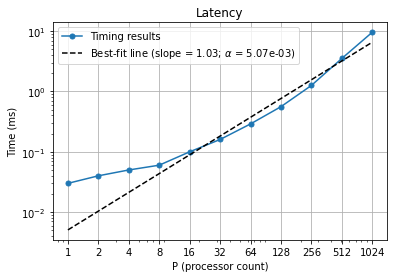

In [11]:
figure(1)
clf()

P = 2**arange(len(T))   # 1,2,4,8,16,..,1024

Ts = 5
L = T - Ts    # Compute "latency"
loglog(P,L,'.-',ms=10,label="Timing results")

ps = polyfit(log(P[3:]),log(L[3:]),1)
m = ps[0]
alpha = exp(ps[1])
loglog(P,exp(polyval(ps,log(P))),'k--',label=r'Best-fit line (slope = {:.2f}; $\alpha$ = {:.2e})'.format(m,alpha))

# Plot latency vs. P

# Make nice tick marks
pstr = ([f'{p}' for p in P])
xticks(P,pstr)

xlabel('P (processor count)')
ylabel('Time (ms)')
title('Latency')

legend()

grid();


<hr style="border-width:4px; border-color:coral"></hr>

## Queues

<hr style="border-width:4px; border-color:c"></hr>


Suppose we have $N$ tasks that need to be completed.  These tasks might be

* Processing $N$ data files, 

* Multiplying a matrix by $N$ vectors, 

* Creating $N$ plots

* Run a simulation with $N$ different choices of parameters

Furthermore, suppose these tasks are relatively independent. The order in which the tasks are carried out doesn't matter, and the tasks do not need to communicate with each other. Furthermore, assume that we expect each task to take roughly the same amount of time.   

Assume that we have $P$ workers, $P \ll N$ (e.g. $P$ is *much* smaller than $N$) to carry out these tasks. Then we have to distribute the $N$ tasks more or less evenly to the $P$ workers.  

Below we do this first using $P$ pipes to communicate tasks to each worker. 

### Create a task list

In [12]:
# Create task list        
N = 10    
task_list = [f"Task {i}" for i in range(N)]    
print(task_list)

['Task 0', 'Task 1', 'Task 2', 'Task 3', 'Task 4', 'Task 5', 'Task 6', 'Task 7', 'Task 8', 'Task 9']


### Define a worker

In [13]:
def do_task_pipe(conn):
    pname = mp.current_process().name
    while True:
        t=conn[1].recv()
        if t=='stop':
            break
        print(f"{pname} is doing {t} \n")
    # ....

### Set up processses and connections

In [15]:
'''
Distribute jobs to specific processors
'''

# Create a connection for P workers
p = 4    
pipes = [mp.Pipe() for i in range(p)]    # "list comprehension"


# TODO : Create P processes;  pass is a connections
workers = []
for i in range(p):
    w=mp.Process(target=do_task_pipe,name=f"worker {i}",args=(pipes[i],))
    workers.append(w)

# TODO : Start processes
for w in workers:
    w.start()

# TODO : Distribute N tasks to P workers
for i in range(N):
    t=task_list[i]
    #send t to a worker
    worker_id = i%p  # i mod p
    pipes[worker_id][0].send(t)

# for each worker, send a stop message
for i in range(p):
    pipes[i][0].send('stop')

# TODO : Wait for processes to complete
for w in workers:
    w.join()

print("Everybody is done!")

worker 1 is doing Task 1 
worker 0 is doing Task 0 
worker 2 is doing Task 2 



worker 0 is doing Task 4 
worker 1 is doing Task 5 
worker 2 is doing Task 6 
worker 3 is doing Task 3 




worker 0 is doing Task 8 
worker 1 is doing Task 9 

worker 3 is doing Task 7 


Everybody is done!


<hr style="border-width:4px; border-color:coral"></hr>

## Using a Queue

<hr style="border-width:4px; border-color:coral"></hr>

A Python Queue carries out the above.  

* A "queue", as the name suggests, is a list of tasks.  As items in queue become available, the tasks can be taken off the queue and completed.  

* Queues are built on top of pipes. 

In [16]:
'''
we can use queues to specifiy which processor does what
'''
queue = mp.Queue()

# Put tasks on the queue
queue.put(task_list[0])

# Remove tasks from the queue

t=queue.get()
print(t)

Task 0


We can use a queue instead of pipes to send tasks to worker processes. 

### Define a worker (queue)

In [17]:
def do_task_queue(queue):
    pname = mp.current_process().name
    while True:
        t=queue.get()
        if t=='stop':
            break
        print(f"{pname} is doing task {t} \n")

In [18]:
# TODO : Create P processes;  pass is a connections
workers = []
for i in range(p):
    w=mp.Process(target=do_task_queue,name=f"worker {i}",args=(queue,))
    workers.append(w)

# TODO : Start processes
for w in workers:
    w.start()

# TODO : Distribute N tasks to P workers
for i in range(N):
    t=task_list[i]
    queue.put(t)

# for each worker, send a stop message
for i in range(p):
    queue.put('stop')

# TODO : Wait for processes to complete
for w in workers:
    w.join()

print("Everybody is done!")

worker 0 is doing task Task 0 
worker 2 is doing task Task 2 
worker 1 is doing task Task 1 



worker 1 is doing task Task 4 
worker 0 is doing task Task 6 
worker 2 is doing task Task 5 
worker 3 is doing task Task 3 




worker 1 is doing task Task 7 
worker 2 is doing task Task 9 
worker 0 is doing task Task 8 



Everybody is done!


### Computing a mean using Queues 

<hr style="border-width:4px; border-color:black"></hr>

In the following, use a Queue to compute the mean of a large data array

In [19]:
import random

M = 2**20
data = [random.random() for i in range(M)]

# ...

print("True sum : ",sum(data)/M)

True sum :  0.4998262403064534


<hr style="border-width:4px; border-color:coral"></hr>

## Shared arrays

<hr style="border-width:4px; border-color:coral"></hr>

Another way to share data between processes is to use a "shared value" or "shared array".  A shared array is passed to a process but every process has the same view of the array. 

You can read more about shared arrays [here](https://superfastpython.com/multiprocessing-shared-ctypes-in-python/). 

We can create values that are shared among processes using shared values and shared arrays. 

### Example : Sharing a value

Below is an example of a "shared value".   To create such a value, we use the MP method `.Value`.   In addition to the actual value, we also need to specify the type of data. 

     d   type double    (double precision, 64 bit) 
     f   type float     (single precision, 32 bit)
     i   type integer
     
To create a shared "value", we use the MP constructor "value" as follows:
        x=mp.Value('d',math.pi)

In [20]:
import math

# Double precision type
x = mp.Value('d',math.pi)
print(x.value)

# Single precision type
y = mp.Value('f',math.pi)
print(y.value)

m = mp.Value('i',3)
print(m.value)

3.141592653589793
3.1415927410125732
3


This value can be modified by the process, and the change will be viewed by other processes. 

In [21]:
def double_value(x):
    x.value *= 2

x = mp.Value('d',math.pi)
njobs = 4
jobs = []
for i in range(njobs):
    p = mp.Process(target=double_value, args=(x,))
    jobs.append(p)

for p in jobs:
    p.start()

for p in jobs:
    p.join()

print(x.value)

50.26548245743669


### Example : Sharing an array

Below is an example of a "shared value".   To create such a value, we use the MP method `.Value`.   In addition to the actual value, we also need to specify the type of data. 

     d   type double    (double precision, 64 bit) 
     f   type float     (single precision, 32 bit)
     i   type integer

In [22]:
def assign_value(i,a):
    a[i] = i

njobs = 4
data = [0]*njobs
print("before : ",data)

a = mp.Array('i',data)

jobs = []
for i in range(njobs):
    p = mp.Process(target=assign_value,args=(i,a))
    jobs.append(p)
    
for p in jobs:
    p.start()
    
for p in jobs:
    p.join()
    
data = [a[i] for i in range(njobs)]
print("after  : ", data)


before :  [0, 0, 0, 0]
after  :  [0, 1, 2, 3]


### Computing a mean using a Shared Array 

<hr style="border-width:4px; border-color:black"></hr>

In the following, use a shared array to compute the mean of a large data array

In [23]:
def do_task_queue(A,queue,queue_result):
    pname = mp.current_process().name
    while True:
        i1,i2=queue.get()
        s=sum(A[i1:i2])
        queue_result.put(S)
        if t=='stop':
            break
        print(f"{pname} is doing task {t} \n")

In [24]:
import random

M = 2**20
data = [random.random() for i in range(M)]

A = mp.Array('d',data)

queue=mp.Queue()


print("True sum : ",sum(data)/M)

True sum :  0.4997983398612593
